# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [1]:
from PIL import Image # Python Imaging Library
import requests
import matplotlib.pyplot as plt
import time

# Jupyter에서 고해상도 이미지를 출력하기 위한 설정
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50 # backbone으로 사용할 resnet50
import torchvision.transforms as T
# PyTorch에서 gradient 계산을 비활성화 하는 코드. inference만 수행할 것이기 때문
torch.set_grad_enabled(False);

## DETR
Here is a minimal implementation of DETR:

In [ ]:
class DETRdemo(nn.Module):
    """
        DETR의 실제 구현은 DETRdemo와 다르다.

        * learned positional encoding (원래 sine 사용)
        * positional encoding은 input에 pass (원래 attention에 pass)
        * fc bbox predictor (원래 MLP)

        성능은 약 ~40 AP정도가 나오며, 1 batch size정도만 지원한다.
    """

    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        # nn.Module을 initialize
        super().__init__()

        # ResNet-50 backbone으로 모델 할당
        self.backbone = resnet50()

        # backbone은 feature map 생성에만 쓰임
        # -> fully-connected layer는 필요 없다는 소리: 모델에서 삭제함
        del self.backbone.fc

        # ResNet-50에서 fc-layer를 삭제하고 나면 마지막 output은 (None, 7, 7, 2048)이다. (HxW가 214x214일 때)
        # ---> Convolution layer가 총 5이기 때문에 descale-resolution이 2^5만큼 될것임.

        # input channel: 2048, output channel: 256(=hidden_dim)
        # 1x1 conv filter를 추가해줌으로써 channel의 차원을 256으로 낮추어 준다.
        # 256차원은 transformer encoder의 input tokens의 dimension이기도 한다. (token의 sequence길이는 가변)
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # 기본 transformer를 추가해준다.
        # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # hidden_dim(=d_model): encoder/decoder의 expected feature input size (default=512)
        # nheads: multihead-attention을 위한 head의 수를 의미한다.
        # num_encoder_layers: sub-encoder-layers의 길이 (default=6)
        # num_decoder_layers: sub-decoder-layers의 길이 (default=6)
        # ... docs 참조
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        # 예측을 위한 prediction heads에 background detection을 위한 1 extra classes를 추가해준다.
        # * original DETR에서 linear_bbox는 3-layer MLP를 사용한다. (여기서는 1개만 쌓았음 output dim은 4차원(bb cordinate)
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries) 를 추가해준다.
        # 100 x 256 차원의 가우시안 분포 (default)
        # 이 때, 100은 transformer decoder의 sequence.
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # * original DETR에서는 sine positional encodings를 사용한다. -> demo에서는 가우시안 분포 사용
        # 이 때 demo 버전에서는 input의 size를 800xn으로 맞춘다. (Resize했음 800<=n<=1600)
        # backbone(=ResNet50)을 통과시키면 H0x(1/32), W0x(1/32)되어서
        # output feature map의 W,H는 50를 넘지 못함
        # row_embed: 행의 위치를 나타내는 임베딩 벡터
        # col_embed: 열의 위치를 나타내는 임베딩 벡터
        # 이를 바탕으로 각 픽셀에 대응시킨 결과물을 1x1 conv layer를 통과한 feature map과 함께 Transformer에 입력
        # -> 실제 논문 상에는 (encoder-decoder 상에 다 입력되긴 함)
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # ResNet-50에서 avg pooling layer전까지 순전파 한다.
        # resnet은 최초의 conv - bn - relu - maxpool을 거친 후
        # conv - bn을 주 구성요소로 하는 bottleneck layer를 많이 통과시킨다.
        # 불러온 resnet50에 다 정의되어 있음
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        # avg-layer는 사용 x
        # 여기서 tensor x의 shape은 [None(=1), 2048, H0//32, W0//32] (H0, W0은 input H, W을 말하는 것임)

        # 위에서 정의한 conv를 통해 256차원의 feature map으로 축소
        h = self.conv(x)
        # [None(=1), 256, H0//32, W0//32]

        # positional encoding을 구성한다.
        H, W = h.shape[-2:]

        # 아래의 positional embeddings을 통해 transformer의 input tokens(1d flattened feature map, 즉 tensor의 h)와 concat함으로써
        # 위치 정보가 없는 input tokens에 위치 정보가 담기게 된다.

        # 높이, 너비 각각 feature map의 size에 해당하는 positional embeddings을 slicing한다.
        # col 정보를 담은 positional embeddings (H x W x 128) --> repeat(H, 1, 1) H는 그냥 차원을 맞추기 위함
        # row 정보를 담은 positional embeddings (H x W x 128)
        # concat을 시켜 transformer의 input tokens의 차원인 256과 일치 시킨다.
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)
        # pos = [625, None(=1), 256] -> 1은 batch size임에 주의!

        # h.flatten(2).permute(2, 0, 1) -> (625, None(=1), 256)으로 맞춰줌
        # 이를 바탕으로 pos + 0.1*h.flatten(2).permutate(2, 0, 1)을 하여 positional encoding한 값을 만들어냄
        # transformer의 input에 넣고, output dim으로는  object queries와 맞춰준다.
        # src(Tensor): - encoder에 투입할 sequence (625, 1, 256)
        # trg(Tensor): - decoder에 투입할 sequence (100, 1, 256)
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        # 결과적으로 transpose(0, 1) -> (1, 100, 256)

        # (1, 100, 256) -> (1, 100, C + 1) 분류해야함
        # (1, 100, 4) -> bounding box 예측
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


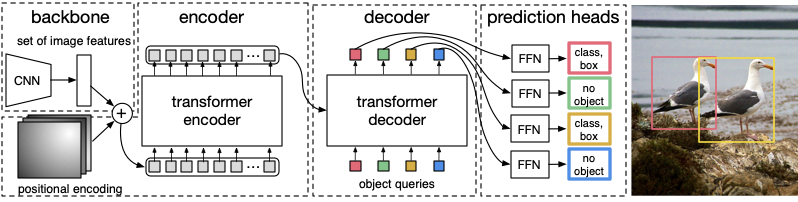

Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

In [ ]:
# DETR 모델을 초기화 한다.
detr = DETRdemo(num_classes=91)

# PyTorch에서 사전 학습된 모델의 가중치를 로드한다.
# map_location='cpu'로 다운로드된 파라미터를 CPU에 로드한다.
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
# print(state_dict)
# 다운로드받은 사전 학습된 모델의 파라미터(가중치 및 편향)을 모델에 로드한다.
# DETR 연구진이 미리 detr_demo에 대한 학습을 진행하고 올려둔 것이다.
detr.load_state_dict(state_dict)

# 모델을 평가 모드로 설정한다. (inference 모드로 설정)
# Dropout, BN등을 적용하기 위해서 해주어야 한다.
detr.eval();

## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

In [ ]:
'''
    < COCO 2017 valk5 >
    'N/A'는 해당 번호의 클래스가 없음을 의미한다.
    이는 모델이 예측한 클래스 번호를 사람이 읽을 수 있는 클래스 이름으로 변환할 수 있게 된다.

    위 주석에서 1~90까지 클래스 인덱스를 가진 80개의 COCO 클래스를 나타냄.
    위에서 pre-trained된 DETR 모델의 출력 클래스는 91차원이 되고, 그중 80개만 사용됨
'''

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

'''
    6개의 서로 다른 색상이 정의되어 있다.
    BB나 Segmentation Mask를 그릴 때 사용된다.
'''
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

In [ ]:
transform = T.Compose([
    # 가장 짧은 측면이 800pixel이 되도록 설정한다. 모델의 입력 크기 조절하기 위함
    # 실제 DETR 논문에서 H, W 고정임.
    T.Resize(800),
    # (H, W, C) -> (C, H, W)
    T.ToTensor(),
    # 각 색상 채널의 값을 정규화 한다. ([mean,..], [std,..]): ImageNet 데이터셋에서의 값
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# output bounding box 후처리 과정
# 그냥 bounding box의 coordinates를 바꾸는 과정이다.
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# DETR 모델에서 이미지를 처리하기 전에 이미지를 일정한 크기로 리사이즈한다.
# 그리고 BB도 리사이즈 되어있을 텐데 이를 원래 이미지 scale로 바꾸어 주는 과정이다.
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

Let's put everything together in a `detect` function:

In [ ]:
# detect 하는 부분
def detect(im, model, transform):

    # input image를 정규화 한다 (batch-size: 1로 ) -> 위에서 None으로 설정한 부분을 다 1로 바꾼 이유
    img = transform(im).unsqueeze(0)

    # demo일 경우 aspect ratio를 0.5와 2사이만 지원
    # 이 범위 밖의 이미지를 사용하고 싶다면 maximum size를 1333이하로 rescaling해야 한다.
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # 모델을 통과시킨다 (forward)
    outputs = model(img)

    # softmax(-1)즉 C+1로 분류했던 Class에 대해 softamx를 진행
    # 그리고 [0, :, :-1]는 첫번째 차원의 첫번째 요소(즉, 첫번째 예측 결과)를 선택하고
    # 마지막 클래스('배경'클래스)를 제외한 모든 클래스에 대한 확률값을 선택한다.
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]

    # probas에서 마지막 차원에 대한 최댓값을 계산하고 최댓값을 담고 있는 텐서를 반환한다.
    # 이에 대해 0.7보다 큰 값에 대한 불리언 텐서를 반환
    keep = probas.max(-1).values > 0.7

    # [0, 1]로 boxes 값을 image scale로 확대한다. -> 값이 1인 불리언만 추출
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

# visualize 하는 부분
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = 'https://farm3.staticflickr.com/2407/2347061407_ba45c7ab99_z.jpg'
url = 'https://news.imaeil.com/inc/photos/2020/11/02/2020110216374231552_l.jpg'
im = Image.open(requests.get(url, stream=True).raw)

start = time.time()

# Detect 한다
scores, boxes = detect(im, detr, transform)

print("Inference time: ", round(time.time() - start, 3), 'sec')

Inference time:  3.801 sec


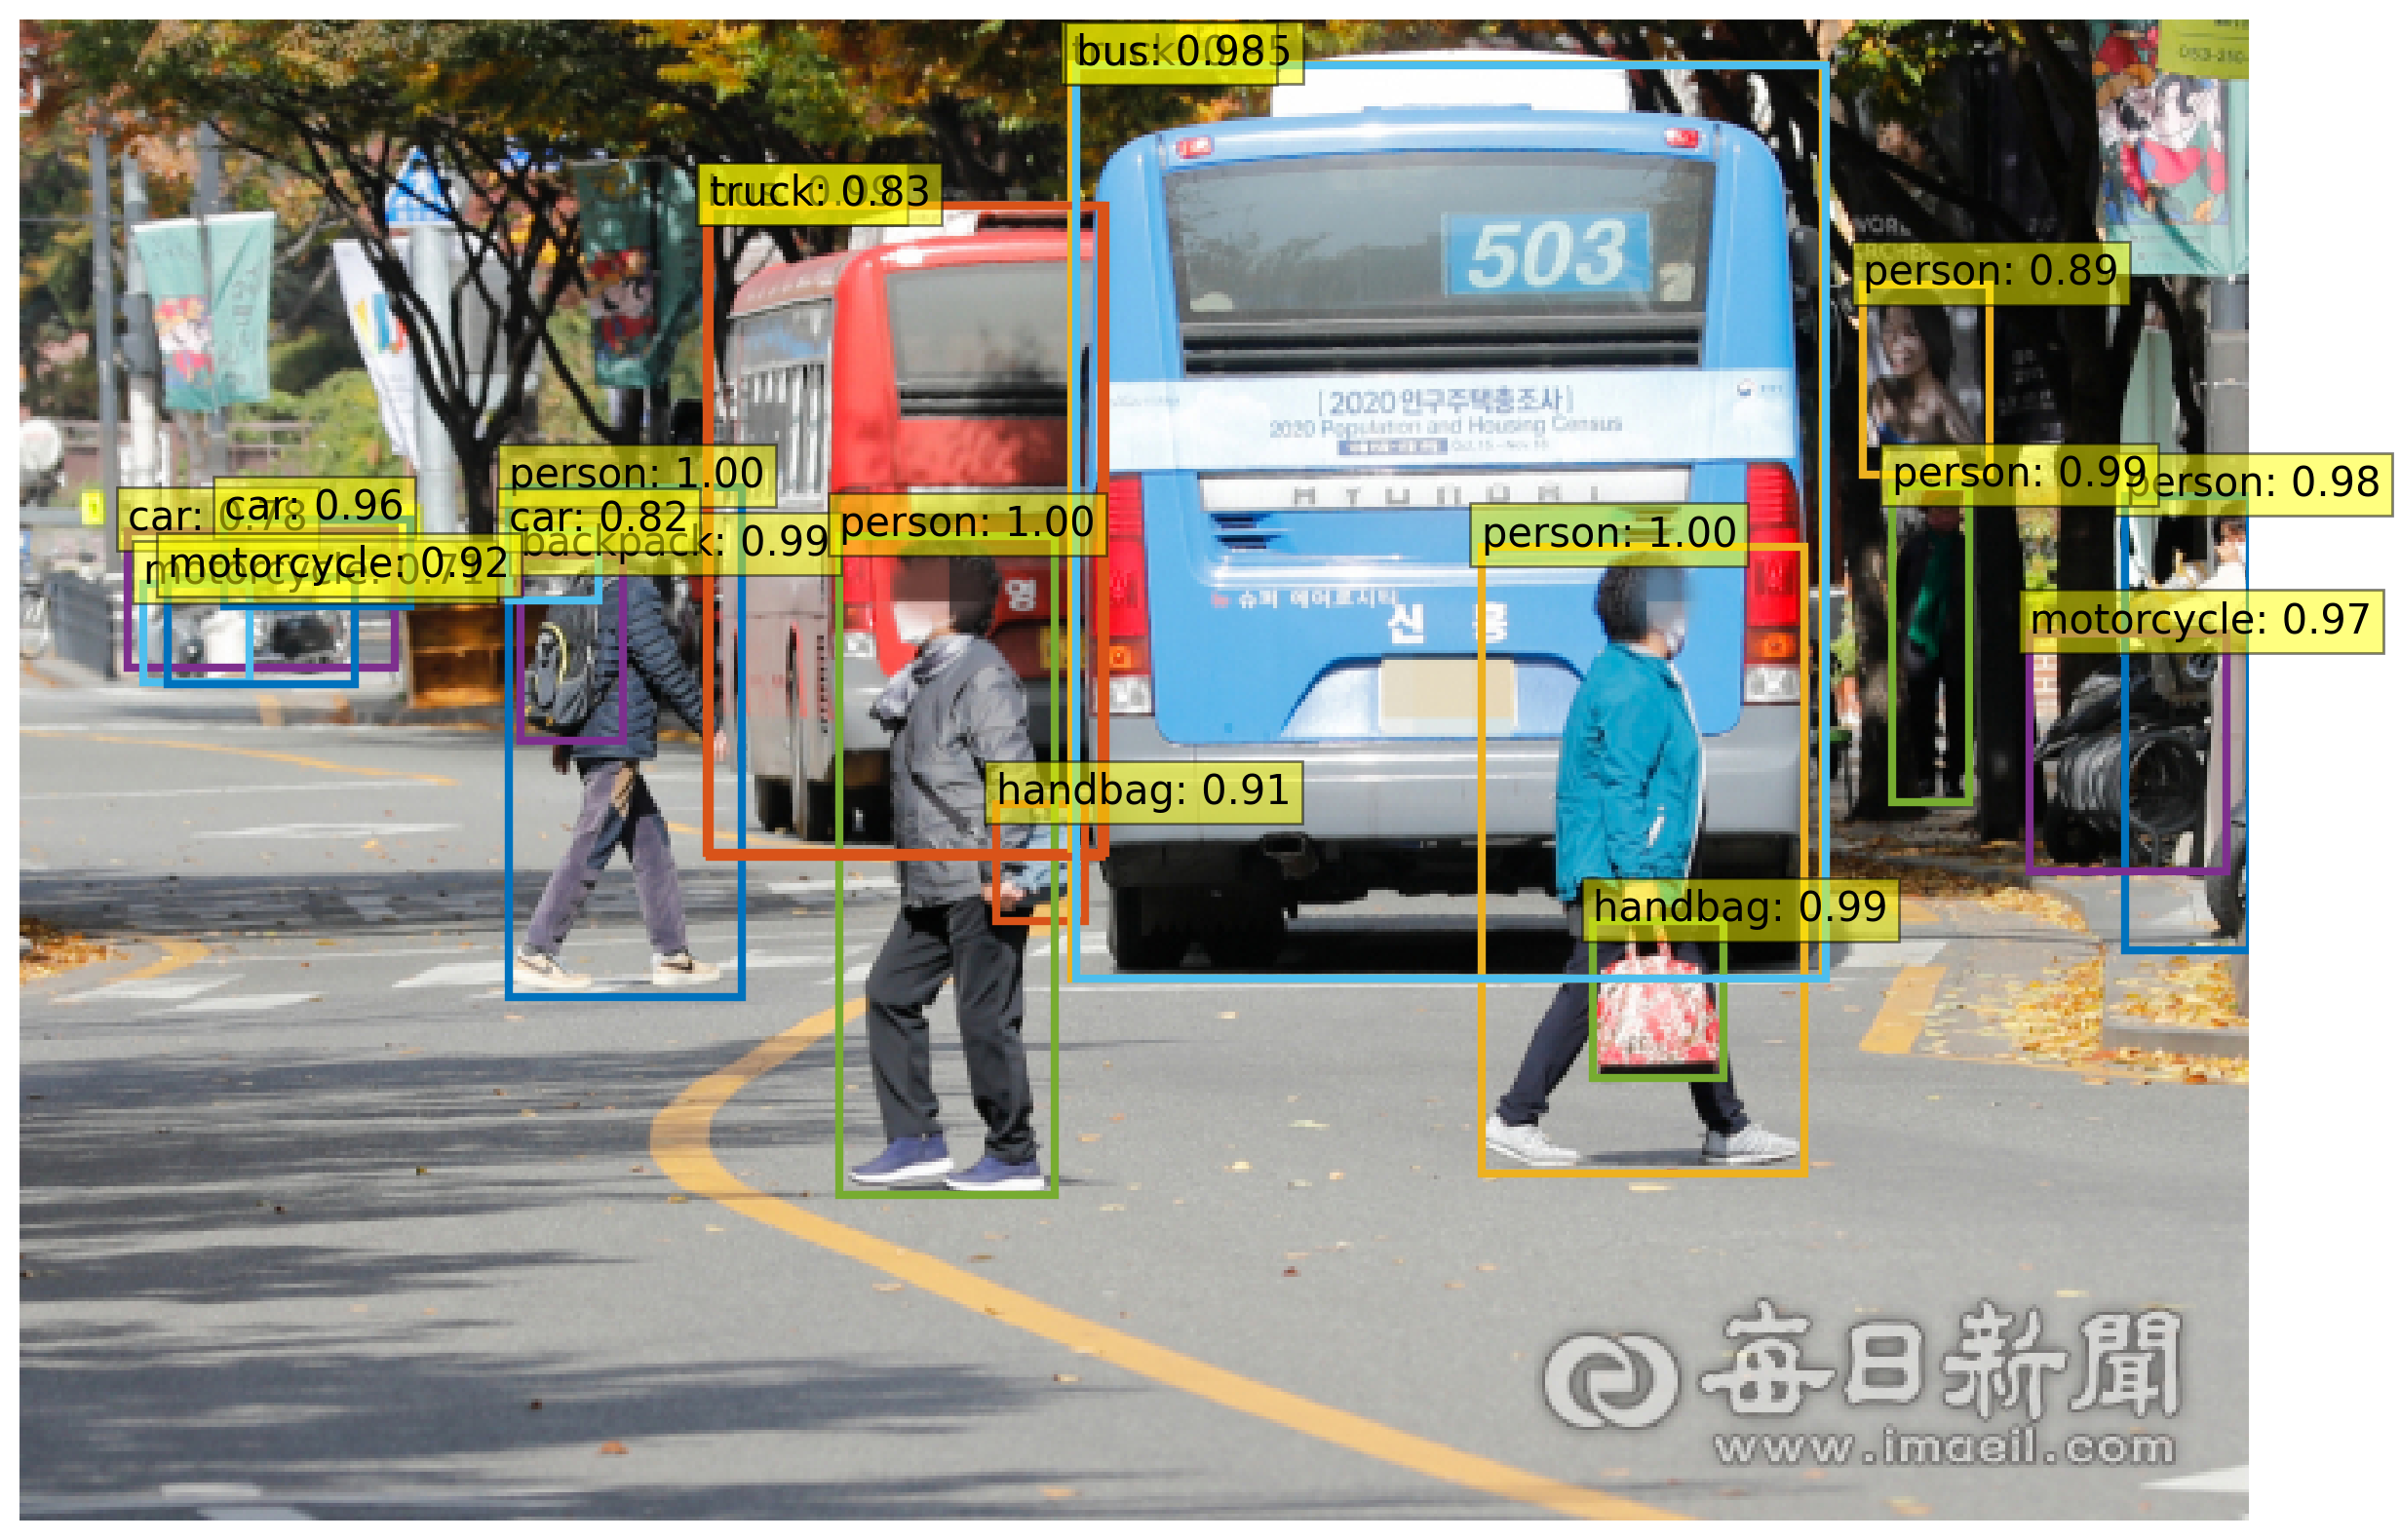

In [ ]:
plot_results(im, scores, boxes)